In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [28]:
from tensorflow.keras.datasets import cifar10

In [29]:
train_ds, test_ds = cifar10.load_data() 
train_ds = tf.data.Dataset.from_tensor_slices(train_ds)

In [30]:
def show_images(images):
    n = len(images)
    for i,image in enumerate(images):
        plt.subplot(1,n,i+1)
        plt.imshow(image)
        plt.axis("off")
    plt.show()

# METHOD 1

In [31]:
IMG_SIZE =32
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_SIZE,IMG_SIZE),
    tf.keras.layers.Rescaling(1/256)
])


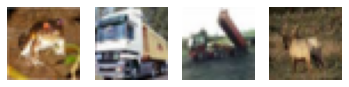

In [32]:
resized_images = train_ds.take(4).map(lambda x,y: resize_and_rescale(x))
show_images(resized_images)

In [33]:
data_augumentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomRotation(factor=.2),
    tf.keras.layers.RandomContrast(factor=(.2,.9),),
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


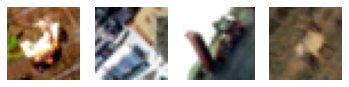

In [34]:
aug_images = resized_images.map(lambda x: data_augumentation(x))
show_images(aug_images)

In [35]:
AUTOTUNE = tf.data.AUTOTUNE
def prepare(ds):
    ds = ds.map(lambda x,y: (resize_and_rescale(x),y),num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x,y: (data_augumentation(x),y),num_parallel_calls=AUTOTUNE)
    return ds.prefetch(buffer_size=AUTOTUNE)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


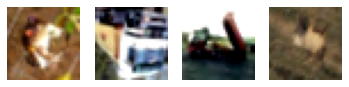

In [36]:
prepared_ds = prepare(train_ds.take(4)) 
show_images(prepared_ds.map(lambda x,y:x))

In [37]:
model = tf.keras.Sequential([resize_and_rescale,data_augumentation,tf.keras.layers.Conv2D(16,3),tf.keras.layers.MaxPooling2D(),])
model.compile()

# Method 2 - Data Augumentation using tf.image

In [20]:
image , label = next(iter(train_ds))

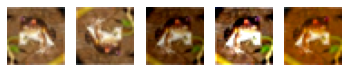

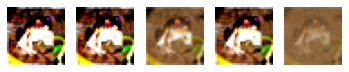

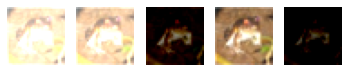

In [21]:
show_images([
    tf.image.flip_left_right(image),
    tf.image.flip_up_down(image),
    tf.image.adjust_brightness(image,-.2),
    tf.image.adjust_contrast(image,2),
    tf.image.adjust_saturation(image,2),
])  

show_images([
    tf.image.stateless_random_contrast(image, lower=.1,upper=5,seed = (i,0))
    for i in range(1,6)
]) 
show_images([
    tf.image.stateless_random_brightness(image, max_delta=.8,seed = (i,0))
    for i in range(1,6)
]) 

In [22]:
def resize_and_rescale(img):
    img = tf.cast(img,tf.float32) 
    img = tf.image.resize(img,(32,32))
    img = img/255.0 
    return img

def augument(img_label,seed):
    image,label = img_label
    image = resize_and_rescale(image)

    
    image = tf.image.stateless_random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
   
    image = tf.image.stateless_random_brightness( image, max_delta=0.5, seed=seed)
    image = tf.clip_by_value(image, 0, 1)
    return image,label

In [23]:
rng = tf.random.Generator.from_seed(1,alg="philox") 

In [24]:
def augument_wrapper(image,label):
    seed = rng.make_seeds(2)[0]  
    image,label = augument((image,label),seed)
    return image,label

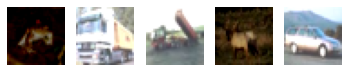

In [25]:
augumented_ds = train_ds.take(5).map(augument_wrapper)
show_images(augumented_ds.map(lambda x,y : x))